<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_5/Taller_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

## Taller 5

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1: Carlos Raúl de la Rosa Peredo**

**Integrante 2: Jhon Stewar Rayo Mosquera**

**NOTA:** El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreApellido1_NombreApellido2_TallerS10.ipynb

**Dataset** : Enlace para descargar el dataset: https://drive.google.com/file/d/1C4zZPQcRY52UzgM8z-gzm4dVtSpSaDmw/view?usp=sharing

**Objetivo**: Contruir modelos de deep learning que ayude a clasificar una imagen en alguna de esas 8 clases del dataset (cada folder en el dataset es una categoría). Va a comparar el performance entre una arquitectura densa y Convnets.


## Punto 1: Clasificación de imágenes con arquitectura densa

Requerimientos básicos:
- Divida el dataset en particiones de entrenamiento, validación y testing.
- Proponga una arquitectura de red neuronal densa con al menos 3 capas.
- Entrene el modelo y genere las curvas de loss vs epoch para los sets de entrenamiento y validación.
- Hacer deploy del modelo (realizar prediccion sobre una imagen dada fuera del dataset).
- Evalue el modelo sobre testing y obtenga el reporte de precision, recall  f1-score. Puede utilizar el macro o micro average.

## Punto 2: Clasificación de imágenes con ConvNets

Requerimientos básicos:
- Contruir una red convolucional de al menos 3 capas convolucionales. Utilice las mismas particiones del punto 1.
- Guardar el modelo proveniente de la red convolucional.
- Hacer deploy del modelo (realizar prediccion sobre una imagen dada).
- De ser necesario realizar estrategias de aumentación de datos

## Punto 3: Comparación

Compare los modelos, cual se comporto mejor?, por qué?

# S O L U C I Ó N

In [3]:
from tensorflow.keras import models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Dropout, Activation, MaxPooling2D, 
                                     Conv2D, Flatten, BatchNormalization)

from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

2024-04-13 12:05:41.084250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 12:05:41.114561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 12:05:41.558799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/raul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D p

## Carga de datos

In [4]:
files = glob('data/*.jpg')

cates = [i[5:i.find('_')] for i in files]

In [5]:
df_data = pd.DataFrame({'path': files, 'label': cates}) 

df_data.label.value_counts()

label
fruit        1000
person        986
car           968
cat           885
flower        843
motorbike     788
airplane      727
dog           702
Name: count, dtype: int64

In [6]:
df_balanced = pd.concat([df_data.query(f"label=='{c}'").sample(702) for c in df_data['label'].unique()], 
                             ignore_index=True)

NUM_CLASSES = df_balanced.label.nunique()

df_balanced.label.value_counts()

label
airplane     702
car          702
motorbike    702
flower       702
dog          702
cat          702
fruit        702
person       702
Name: count, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['path'], df_balanced['label'], test_size=0.20, random_state=33)

X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.7, random_state=34)

len(X_train), len(X_test), len(X_val)

(4492, 786, 338)

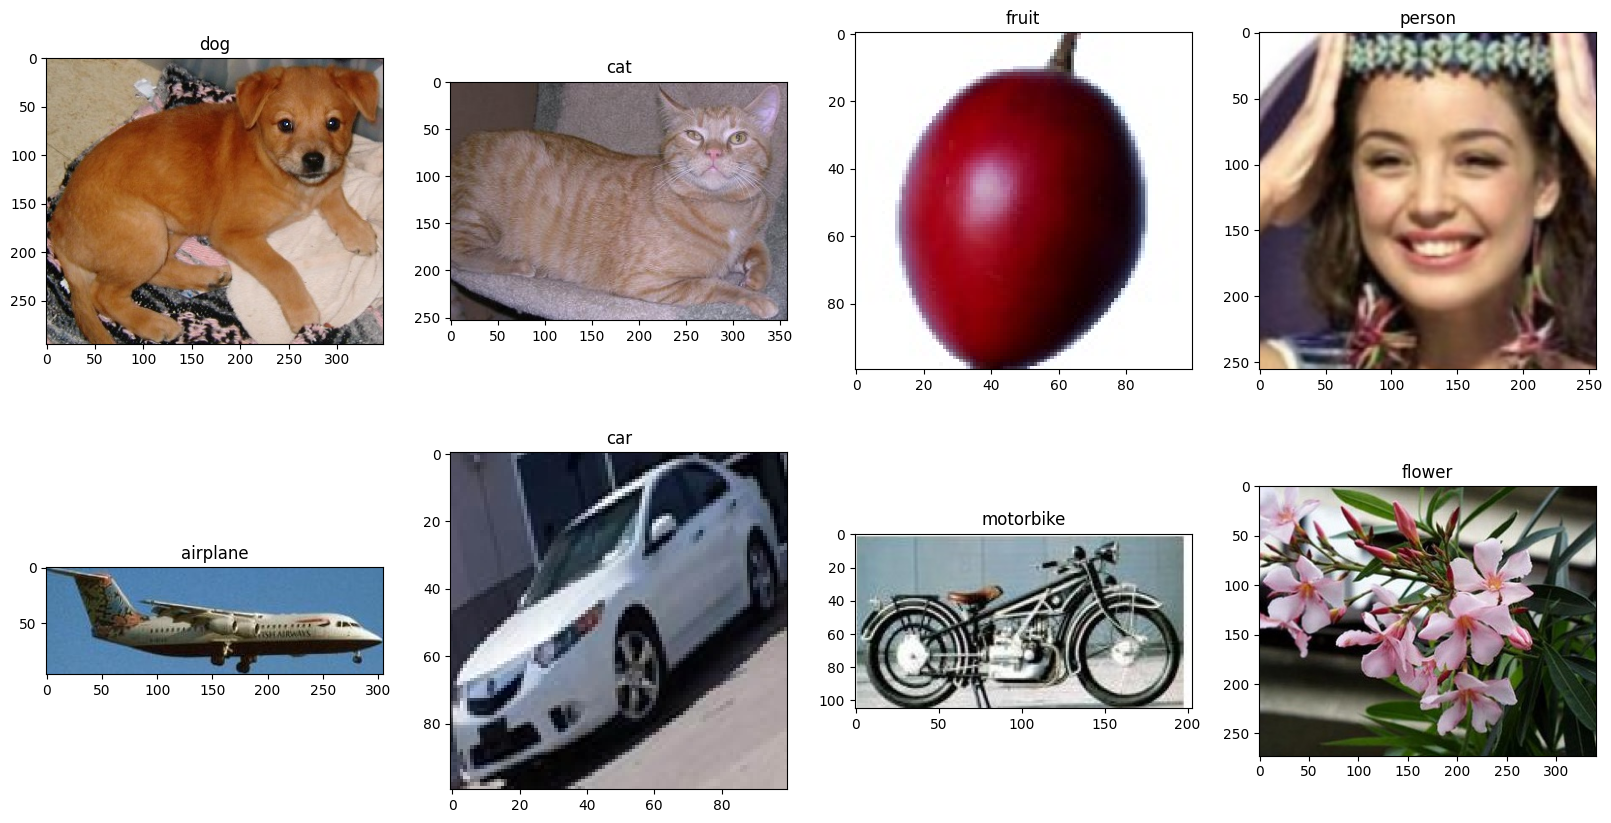

In [8]:
#observamos que las imágenes tienen tamaños diferentes
plt.figure(figsize=(20,20))

for i in range(2):
    for j in range(4):
        plt.subplot(i+1, 4, j+1)
        plt.title(df_balanced.label.unique()[i*4+j])
        img = cv2.imread(df_balanced.query(f"label=='{df_balanced.label.unique()[i*4+j]}'").sample(1, random_state=34).path.values[0])
        # Mostrar la imagen
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        
plt.show()

### Procesar Datos de entrenamiento

In [9]:
IMG_SIZE = 128
BATCH_SIZE = 50


def preprocessig_data(data, flat=False):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Corregido a BGR2GRAY
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0 # normalizamos los pixeles de la imagen
            img = img.astype('float32') # Asegura el tipo correcto antes de añadir a la lista
            X.append(img)
    
    X = np.array(X)
    if flat:
        X = X.reshape((len(X), IMG_SIZE * IMG_SIZE))  # Para una red completamente conectada
    else:
        X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) # Para redes que necesiten un canal explícito
    
    return X



def prep_img(img_path, flat=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0

    img = np.array(img).astype('float32')
    
        
    img = img.reshape(-1,img.shape[0], img.shape[1], 1)
    return img



In [10]:
X_train_p = preprocessig_data(X_train)
X_val_p = preprocessig_data(X_val)

le = LabelEncoder()
#Primero tranformamos las clases en numeros
y_train_p = le.fit_transform(y_train)
y_val_p = le.transform(y_val)

#Las llevamos a varias columnas, similar a OneHotEncoding
y_train_p = to_categorical(y_train_p, num_classes=df_balanced.label.nunique())
y_val_p = to_categorical(y_val_p, num_classes=df_balanced.label.nunique())


datagen = ImageDataGenerator(
    rotation_range=10,  # Rotar imágenes aleatoriamente en el rango de 0 a 10 grados
    zoom_range=0.1,  # Zoom aleatorio
    width_shift_range=0.1,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,  # Desplazamiento vertical aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    vertical_flip=False  # No voltear imágenes verticalmente
)

train_generator = datagen.flow(
    X_train_p, y_train_p,
    batch_size=BATCH_SIZE  # Puedes ajustar este tamaño de lote según las necesidades de tu entrenamiento
)

## 1. MLP

In [17]:

mlp_model = models.Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    # Primera capa densa
    Dense(1024),
    BatchNormalization(),  # Capa de normalización después de la capa densa
    Activation('relu'),  # Función de activación después de la normalización
    Dropout(0.05),
    
    # Primera capa densa
    Dense(512),
    BatchNormalization(),  # Capa de normalización después de la capa densa
    Activation('relu'),  # Función de activación después de la normalización
    Dropout(0.10),
    
    # Segunda capa densa
    Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.15),
    
    # Tercera capa densa
    Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.20),
    
    Dense(NUM_CLASSES, activation='softmax')
])

mlp_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']
              )


early = callbacks.EarlyStopping(monitor='val_loss', 
                                patience=5,
                                restore_best_weights=True,
                                )

checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='models/mlp_best.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True) 

history_no_conv = mlp_model.fit(train_generator, validation_data=(X_val_p, y_val_p),
                                epochs = 100, callbacks=[checkpoint_callback])

Epoch 1/100


/home/raul/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - categorical_accuracy: 0.3793 - loss: 24.1470 - val_categorical_accuracy: 0.2041 - val_loss: 11.9812
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - categorical_accuracy: 0.5232 - loss: 8.1818 - val_categorical_accuracy: 0.5237 - val_loss: 4.6501
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - categorical_accuracy: 0.5536 - loss: 3.8721 - val_categorical_accuracy: 0.5296 - val_loss: 3.2337
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - categorical_accuracy: 0.5808 - loss: 2.7818 - val_categorical_accuracy: 0.6598 - val_loss: 2.6511
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - categorical_accuracy: 0.5816 - loss: 2.3434 - val_categorical_accuracy: 0.5385 - val_loss: 2.3969
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - categorical_accuracy: 0.5733 - loss: 2.2359 - val_categorical_accuracy: 0.5266 - val_loss: 2.3220
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - categorical_accuracy: 0.6041 - loss: 2.1525 

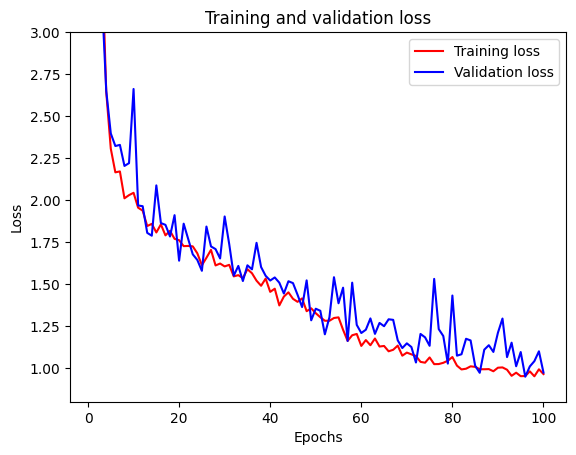

In [23]:
history_dict = history_no_conv.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(.8, 3)
plt.show()

### Evaluación MLP

In [24]:
X_test_p = preprocessig_data(X_test)
y_test_p = le.transform(y_test)
y_test_p = to_categorical(y_test_p)

In [25]:
score_mlp_model = mlp_model.evaluate(X_test_p, y_test_p)

#modelo_base
y_pred_base = mlp_model.predict(X_test_p)
y_pred_base = y_pred_base.argmax(axis=-1)

Y_test = y_test_p.argmax(axis=-1)
print()
print('Reporte para el modelo MLP construido'.center(60,'-'))
print(f'Test loss: {score_mlp_model[0]}\nTest Accuracy: {score_mlp_model[1]}')
print()
print(classification_report(Y_test, y_pred_base, target_names=le.classes_))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.7526 - loss: 0.8899
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

-----------Reporte para el modelo MLP construido------------
Test loss: 0.9138250350952148
Test Accuracy: 0.7480915784835815

              precision    recall  f1-score   support

    airplane       0.67      0.94      0.78        94
         car       0.78      0.84      0.80        91
         cat       0.57      0.43      0.49        87
         dog       0.53      0.52      0.52        94
      flower       0.76      0.37      0.50       111
       fruit       0.97      1.00      0.99       115
   motorbike       0.87      0.90      0.88        93
      person       0.75      0.97      0.85       101

    accuracy                           0.75       786
   macro avg       0.74      0.75      0.73       786
weighted avg       0.75      0.75      0.73       786



### New Image

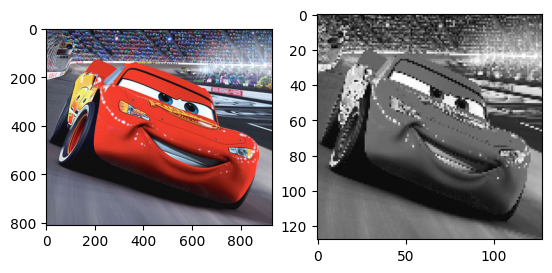

In [34]:
new_img = cv2.imread('./test_img/car_test.jpeg')
img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
new_img_prep = prep_img('./test_img/car_test.jpeg')

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.imshow(new_img_prep[0], cmap='gray')

print(f'Clasification = {le.classes_[np.argmax(mlp_model.predict(new_img_prep))]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Clasification = dog


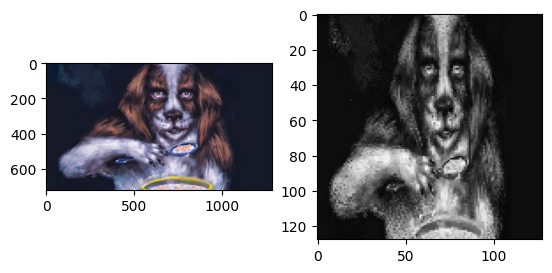

In [37]:
new_img = cv2.imread('./test_img/dog_test.jpg')
img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
new_img_prep = prep_img('./test_img/dog_test.jpg')

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.imshow(new_img_prep[0], cmap='gray')

print(f'Clasification = {le.classes_[np.argmax(mlp_model.predict(new_img_prep))]}')

## 2. CNN